In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, make_scorer
import imblearn.over_sampling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sqlalchemy import create_engine
import pickle


plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

pd.options.display.max_columns = 75

In [2]:
from decoding_functions import decoder_a_score, decoder_age, decoder_c_score, decoder_country, \
                                decoder_e_score, decoder_educ_lvl, decoder_ethnicity, \
                                decoder_n_score, decoder_o_score, decoder_sex, decoder_user_non_user

In [8]:
cnx = create_engine('postgresql://ubuntu@3.22.168.204:5432/drug_data')
df = pd.read_sql_query('''select * from drug_data_full''', cnx)
df.head()

,id,age,sex,educ_lvl,country,ethnicity,n_score,e_score,o_score,a_score,c_score,i_score,s_score,alcohol,amphet,amyl,benzos,caffeine,cannabis,choco,coke,crack,ecstacy,heroin,ketamine,inhalants,acid,methadone,mushrooms,nicotine,semer,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [9]:
# df.to_pickle('drug_data.pkl')

In [3]:
df = pd.read_pickle('drug_data.pkl')

In [4]:
df['age'] = df['age'].apply(decoder_age)
df['sex'] = df['sex'].apply(decoder_sex)
df['educ_lvl'] = df['educ_lvl'].apply(decoder_educ_lvl)
df['country'] = df['country'].apply(decoder_country)
df['ethnicity'] = df['ethnicity'].apply(decoder_ethnicity)
df['n_score'] = df['n_score'].apply(decoder_n_score)
df['e_score'] = df['e_score'].apply(decoder_e_score)
df['o_score'] = df['o_score'].apply(decoder_o_score)
df['c_score'] = df['c_score'].apply(decoder_c_score)
df['a_score'] = df['a_score'].apply(decoder_a_score)
for i in list(range(13,32)):
    df.iloc[:, i] = df.iloc[:, i].apply(decoder_user_non_user)

In [5]:
df.head()

,id,age,sex,educ_lvl,country,ethnicity,n_score,e_score,o_score,a_score,c_score,i_score,s_score,alcohol,amphet,amyl,benzos,caffeine,cannabis,choco,coke,crack,ecstacy,heroin,ketamine,inhalants,acid,methadone,mushrooms,nicotine,semer,vsa
0,1,35-44,F,Prof Cert,UK,Wht/Asn,39,36,42,37,42,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,25-34,M,PhD,UK,White,29,52,55,48,41,-0.71126,-0.21575,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0
2,3,35-44,M,Prof Cert,UK,White,31,45,40,32,34,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,18-24,F,Masters,UK,White,34,34,46,47,46,-1.37983,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,35-44,F,PhD,UK,White,43,28,43,41,50,-0.21712,-0.21575,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df['i_score'] = df['i_score'].astype(float)
df['s_score'] = df['s_score'].astype(float)

In [6]:
dummies_df = pd.get_dummies(df)

In [7]:
full_df = dummies_df.drop(['id', 'heroin', 'methadone'], axis = 1)
full_df.insert(0, 'target', dummies_df['heroin'].add(dummies_df['methadone']).replace(2, 1))
full_df.head()

In [139]:
X_base = full_df.drop('target', axis = 1)
X_base.head()

,n_score,e_score,o_score,a_score,c_score,i_score,s_score,alcohol,amphet,amyl,benzos,caffeine,cannabis,choco,coke,crack,ecstacy,ketamine,inhalants,acid,mushrooms,nicotine,semer,vsa,age_18-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,sex_F,sex_M,educ_lvl_Left at 16,educ_lvl_Left at 17,educ_lvl_Left at 18,educ_lvl_Left before 16,educ_lvl_Masters,educ_lvl_PhD,educ_lvl_Prof Cert,educ_lvl_Some college,educ_lvl_Undergrad,country_Australia,country_Canada,country_Ireland,country_New Zealand,country_Other,country_UK,country_USA,ethnicity_Asian,ethnicity_Black,ethnicity_Blk/Asn,ethnicity_Other,ethnicity_White,ethnicity_Wht/Asn,ethnicity_Wht/Blk
0,39,36,42,37,42,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,29,52,55,48,41,-0.71126,-0.21575,1,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,31,45,40,32,34,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,34,34,46,47,46,-1.37983,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,43,28,43,41,50,-0.21712,-0.21575,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [140]:
X_base.describe()

,n_score,e_score,o_score,a_score,c_score,i_score,s_score,alcohol,amphet,amyl,benzos,caffeine,cannabis,choco,coke,crack,ecstacy,ketamine,inhalants,acid,mushrooms,nicotine,semer,vsa,age_18-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,sex_F,sex_M,educ_lvl_Left at 16,educ_lvl_Left at 17,educ_lvl_Left at 18,educ_lvl_Left before 16,educ_lvl_Masters,educ_lvl_PhD,educ_lvl_Prof Cert,educ_lvl_Some college,educ_lvl_Undergrad,country_Australia,country_Canada,country_Ireland,country_New Zealand,country_Other,country_UK,country_USA,ethnicity_Asian,ethnicity_Black,ethnicity_Blk/Asn,ethnicity_Other,ethnicity_White,ethnicity_Wht/Asn,ethnicity_Wht/Blk
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,35.921485,39.576127,45.762334,42.866313,41.437135,0.007216,-0.003292,0.822812,0.12626,0.021751,0.158621,0.935809,0.418037,0.947480,0.084350,0.010610,0.127321,0.041910,0.127851,0.088064,0.084350,0.464191,0.000531,0.018037,0.341114,0.255172,0.188859,0.155968,0.049337,0.009549,0.499735,0.500265,0.052520,0.015915,0.053050,0.014854,0.150133,0.047215,0.143236,0.268435,0.254642,0.028647,0.046154,0.010610,0.002653,0.062599,0.553846,0.295491,0.013793,0.017507,0.001592,0.033422,0.912467,0.010610,0.010610
std,9.135869,6.771769,6.579641,6.438106,6.966625,0.954435,0.963701,0.381929,0.33223,0.145907,0.365419,0.245158,0.493367,0.223132,0.277986,0.102485,0.333421,0.200436,0.334013,0.283463,0.277986,0.498848,0.023033,0.133121,0.474209,0.436074,0.391501,0.362921,0.216628,0.097277,0.500133,0.500133,0.223132,0.125180,0.224193,0.121001,0.357296,0.212154,0.350406,0.443263,0.435775,0.166857,0.209874,0.102485,0.051448,0.242305,0.497224,0.456384,0.116662,0.131184,0.039873,0.179783,0.282690,0.102485,0.102485
min,12.000000,16.000000,24.000000,12.000000,17.000000,-2.555240,-2.078480,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,35.000000,41.000000,39.000000,37.000000,-0.711260,-0.525930,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,36.000000,40.000000,46.000000,43.000000,42.000000,-0.217120,0.079870,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,42.000000,44.000000,51.000000,48.000000,46.000000,0.529750,0.765400,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,

In [141]:
y_base = full_df['target']
y_base.value_counts()

0    1689
1     196
Name: target, dtype: int64

In [142]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size = .2, random_state = 42)

In [17]:
pair_plotting_behav_scores = pd.concat([y_base_train, X_base_train.iloc[:, 0:7]], axis=1).rename(columns = {0: 'target'})

In [14]:
pct_to_target_drug_survey = pd.concat([y_base_train, X_base_train.iloc[:, 7:24]], axis=1).rename(columns = {0: 'target'})

In [15]:
pct_to_target_demographics = pd.concat([y_base_train, X_base_train.iloc[:, 24:]], axis=1).rename(columns = {0: 'target'})

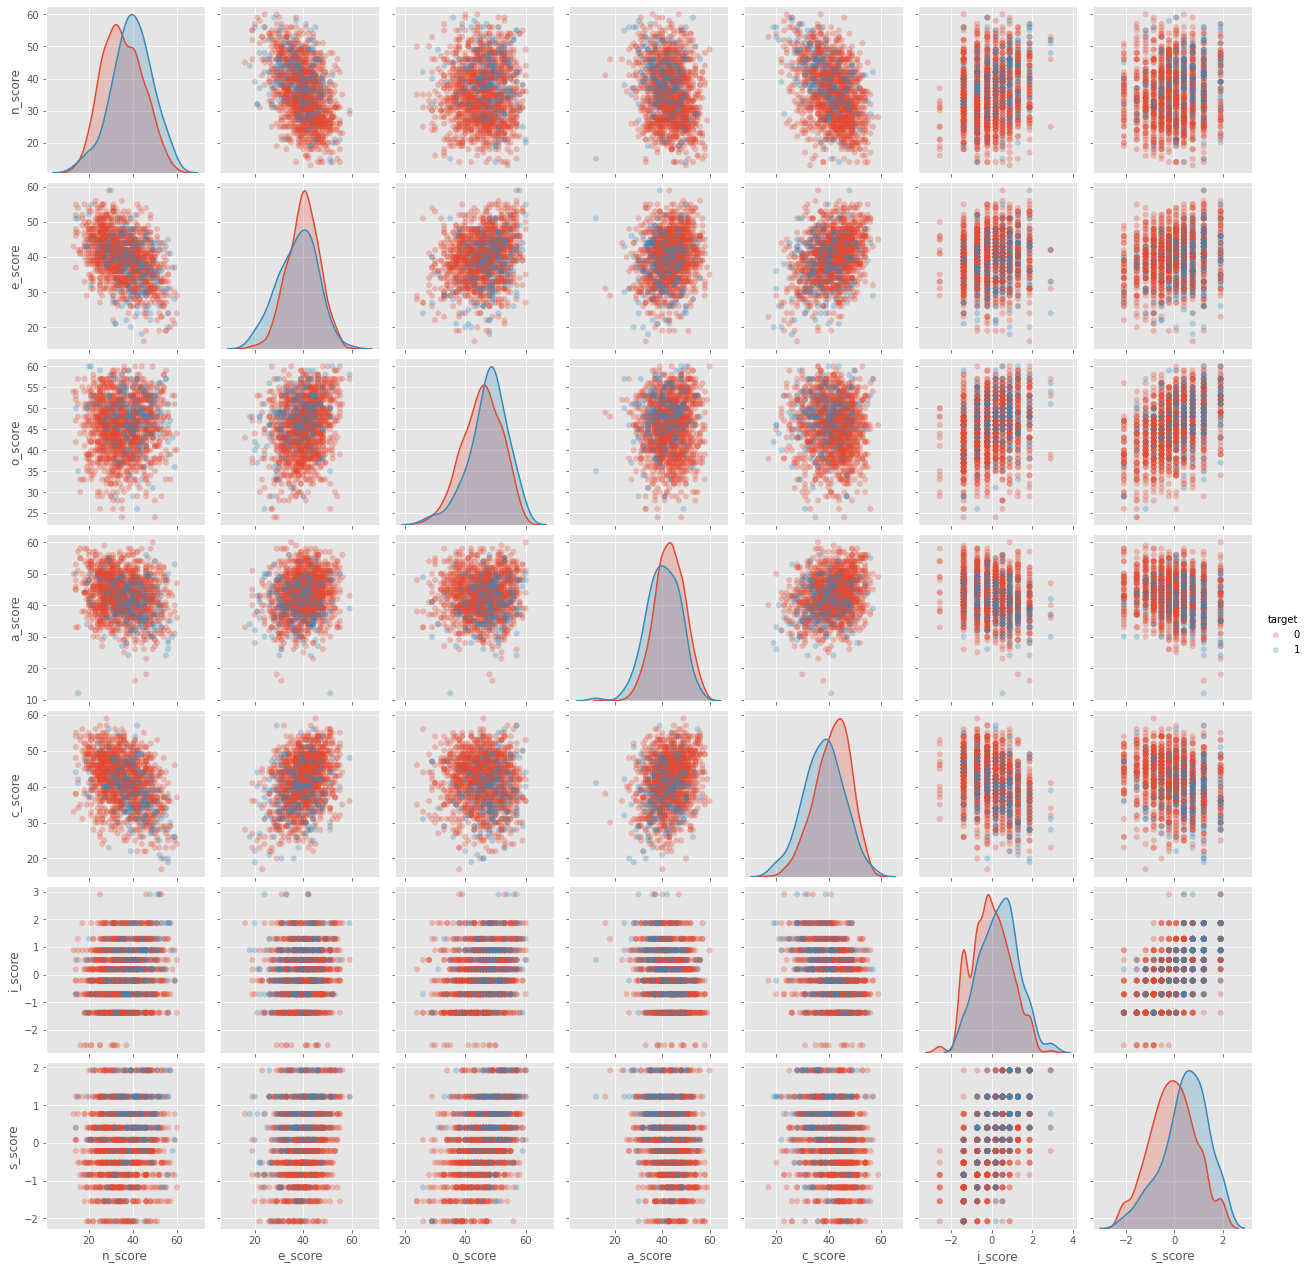

In [16]:
sns.pairplot(pair_plotting_behav_scores,hue='target', plot_kws=dict(alpha=.3, edgecolor='none'))

In [17]:
drug_use_pct_to_target_dict = {}
for col in pct_to_target_drug_survey.columns[1:]:
    drug_use_pct_to_target_dict[col] = pct_to_target_drug_survey.groupby(col)['target'].mean()

drug_use_pct_to_target_df = pd.DataFrame(drug_use_pct_to_target_dict)
drug_use_pct_to_target_df

,alcohol,amphet,amyl,benzos,caffeine,cannabis,choco,coke,crack,ecstacy,ketamine,inhalants,acid,mushrooms,nicotine,semer,vsa
0,0.155556,0.073282,0.101085,0.053417,0.086022,0.049369,0.168675,0.091697,0.097855,0.100763,0.101449,0.084977,0.099636,0.098053,0.064356,0.103517,0.099730
1,0.092084,0.303030,0.205882,0.374468,0.104594,0.177394,0.099649,0.235772,0.625000,0.121212,0.152542,0.231579,0.142857,0.165289,0.148571,0.000000,0.333333


In [20]:
demographics_pct_to_target_dict = {}
for col in pct_to_target_demographics.columns[1:]:
    demographics_pct_to_target_dict[col] = pct_to_target_demographics.groupby(col)['target'].mean()

demographics_pct_to_target_df = pd.DataFrame(demographics_pct_to_target_dict)
demographics_pct_to_target_df

,age_18-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,sex_F,sex_M,educ_lvl_Left at 16,educ_lvl_Left at 17,educ_lvl_Left at 18,educ_lvl_Left before 16,educ_lvl_Masters,educ_lvl_PhD,educ_lvl_Prof Cert,educ_lvl_Some college,educ_lvl_Undergrad,country_Australia,country_Canada,country_Ireland,country_New Zealand,country_Other,country_UK,country_USA,ethnicity_Asian,ethnicity_Black,ethnicity_Blk/Asn,ethnicity_Other,ethnicity_White,ethnicity_Wht/Asn,ethnicity_Wht/Blk
0,0.079920,0.093888,0.115037,0.114961,0.107143,0.103679,0.141522,0.065876,0.102941,0.102564,0.09944,0.102892,0.114152,0.106844,0.107502,0.083333,0.109637,0.102669,0.100968,0.104097,0.103654,0.105524,0.205052,0.039548,0.104909,0.104730,0.103654,0.103567,0.111111,0.101206,0.101945
1,0.149901,0.131926,0.054983,0.042017,0.037500,0.076923,0.065876,0.141522,0.112500,0.153846,0.17500,0.142857,0.043668,0.039474,0.079070,0.158416,0.084881,0.127660,0.161290,0.052632,0.000000,0.072917,0.021557,0.255605,0.000000,0.035714,0.000000,0.100000,0.102695,0.312500,0.235294


In [143]:
dummym = DummyClassifier(strategy='stratified', random_state=42)
dummym.fit(X_base_train, y_base_train)
fbeta_score(y_base_test, dummym.predict(X_base_test), beta = 3), roc_auc_score(y_base_test, dummym.predict_proba(X_base_test)[:, 1])

(0.050125313283208024, 0.4701038575667656)

In [30]:
X_base_train, y_base_train = np.array(X_base_train), np.array(y_base_train)

In [25]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)
base_logreg_val_fbeta, base_logreg_val_roc_auc = [], []
base_knn_val_fbeta, base_knn_val_roc_auc = [], []
base_dtree_val_fbeta, base_dtree_val_roc_auc = [], []
base_forest_val_fbeta, base_forest_val_roc_auc = [], []
base_svc_val_fbeta, base_svc_val_roc_auc = [], []

std = StandardScaler()
fbeta_three_scorer = make_scorer(fbeta_score, beta = 3)

logm = LogisticRegression(max_iter=10000)
knnm = KNeighborsClassifier()
forestm = RandomForestClassifier(class_weight= {0: 1, 1: 4})
svcm = svm.SVC(probability=True)

log_params = {'C': np.logspace(0, 3, 100)}
knn_params = {'n_neighbors': np.arange(4,11)}
forest_params = {'n_estimators': [50, 100, 150, 200], 'n_jobs': np.arange(1,6)}
svc_params = {'C': np.logspace(0, 3, 100)}

for train_ind, val_ind in skf.split(X_base_train, y_base_train):
    
    X_train, y_train = X_base_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_base_train[val_ind], y_base_train[val_ind]
    
    std = StandardScaler()
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    gscv_log = GridSearchCV(estimator=logm, param_grid=log_params, scoring=fbeta_three_scorer)
    gscv_log.fit(X_train_sc, y_train)
    
    gscv_knn = GridSearchCV(estimator=knnm, param_grid=knn_params, scoring=fbeta_three_scorer)
    gscv_knn.fit(X_train_sc, y_train)
    
    dtreem = DecisionTreeClassifier(max_depth=7)
    dtreem.fit(X_train_sc, y_train)
    
    gscv_forest = GridSearchCV(estimator=forestm, param_grid=forest_params, scoring=fbeta_three_scorer)
    gscv_forest.fit(X_train_sc, y_train)

    gscv_svc = GridSearchCV(estimator=svcm, param_grid=svc_params, scoring=fbeta_three_scorer)
    gscv_svc.fit(X_train_sc, y_train)

    base_logreg_val_fbeta.append(fbeta_score(y_val, gscv_log.predict(X_val_sc), beta = 3))
    base_logreg_val_roc_auc.append(roc_auc_score(y_val, gscv_log.predict_proba(X_val_sc)[:, 1]))
    base_knn_val_fbeta.append(fbeta_score(y_val, gscv_knn.predict(X_val_sc), beta = 3))
    base_knn_val_roc_auc.append(roc_auc_score(y_val, gscv_knn.predict_proba(X_val_sc)[:, 1]))
    base_dtree_val_fbeta.append(fbeta_score(y_val, dtreem.predict(X_val_sc), beta = 3))
    base_dtree_val_roc_auc.append(roc_auc_score(y_val, dtreem.predict_proba(X_val_sc)[:, 1]))
    base_forest_val_fbeta.append(fbeta_score(y_val, gscv_forest.predict(X_val_sc), beta = 3))
    base_forest_val_roc_auc.append(roc_auc_score(y_val, gscv_forest.predict_proba(X_val_sc)[:, 1]))
    base_svc_val_fbeta.append(fbeta_score(y_val, gscv_svc.predict(X_val_sc), beta = 3))
    base_svc_val_roc_auc.append(roc_auc_score(y_val, gscv_svc.predict_proba(X_val_sc)[:, 1]))

print(f'Simple mean base logreg model val fbeta: {np.mean(base_logreg_val_fbeta):.3f} +- {np.std(base_logreg_val_fbeta):.3f}')
print(f'Simple mean base logreg model val roc auc: {np.mean(base_logreg_val_roc_auc):.3f} +- {np.std(base_logreg_val_roc_auc):.3f}', '\n')

print(f'Simple mean base knn model val fbeta: {np.mean(base_knn_val_fbeta):.3f} +- {np.std(base_knn_val_fbeta):.3f}')
print(f'Simple mean base knn model val roc auc: {np.mean(base_knn_val_roc_auc):.3f} +- {np.std(base_knn_val_roc_auc):.3f}', '\n')

print(f'Simple mean base dtree model val fbeta: {np.mean(base_dtree_val_fbeta):.3f} +- {np.std(base_dtree_val_fbeta):.3f}')
print(f'Simple mean base dtree model val roc auc: {np.mean(base_dtree_val_roc_auc):.3f} +- {np.std(base_dtree_val_roc_auc):.3f}', '\n')

print(f'Simple mean base forest model val fbeta: {np.mean(base_forest_val_fbeta):.3f} +- {np.std(base_forest_val_fbeta):.3f}')
print(f'Simple mean base forest model val roc auc: {np.mean(base_forest_val_roc_auc):.3f} +- {np.std(base_logreg_val_fbeta):.3f}', '\n')

print(f'Simple mean base svc model val fbeta: {np.mean(base_svc_val_fbeta):.3f} +- {np.std(base_svc_val_fbeta):.3f}')
print(f'Simple mean base svc model val roc auc: {np.mean(base_svc_val_roc_auc):.3f} +- {np.std(base_svc_val_roc_auc):.3f}')


Simple mean base logreg model val fbeta: 0.276 +- 0.070
Simple mean base logreg model val roc auc: 0.833 +- 0.046 

Simple mean base knn model val fbeta: 0.158 +- 0.057
Simple mean base knn model val roc auc: 0.743 +- 0.040 

Simple mean base dtree model val fbeta: 0.304 +- 0.073
Simple mean base dtree model val roc auc: 0.749 +- 0.058 

Simple mean base forest model val fbeta: 0.077 +- 0.056
Simple mean base forest model val roc auc: 0.838 +- 0.070 

Simple mean base svc model val fbeta: 0.264 +- 0.117
Simple mean base svc model val roc auc: 0.773 +- 0.057


In [94]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)
random_os_logreg_val_fbeta, smote_os_logreg_val_fbeta = [], []
random_os_logreg_val_roc_auc, smote_os_logreg_val_roc_auc = [], []
random_os_knn_val_fbeta, smote_os_knn_val_fbeta = [], []
random_os_knn_val_roc_auc, smote_os_knn_val_roc_auc = [], []
random_os_dtree_val_fbeta, smote_os_dtree_val_fbeta = [], []
random_os_dtree_val_roc_auc, smote_os_dtree_val_roc_auc = [], []
random_os_forest_val_fbeta, smote_os_forest_val_fbeta = [], []
random_os_forest_val_roc_auc, smote_os_forest_val_roc_auc = [], []
random_os_svc_val_fbeta, smote_os_svc_val_fbeta = [], []
random_os_svc_val_roc_auc, smote_os_svc_val_roc_auc = [], []

std = StandardScaler()
fbeta_three_scorer = make_scorer(fbeta_score, beta = 3)
log_params = {'C': np.logspace(0, 3, 100)}
knn_params = {'n_neighbors': np.arange(4,11)}
forest_params = {'n_estimators': [50, 100, 150, 200], 'n_jobs': np.arange(1,6)}
svc_params = {'C': np.logspace(0, 3, 100)}

for train_ind, val_ind in skf.split(X_base_train, y_base_train):
    
    X_train, y_train = X_base_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_base_train[val_ind], y_base_train[val_ind]
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)
    
    smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    X_train_sc_smote, y_train_smote = smote.fit_sample(X_train_sc, y_train)


    random_os_logm = LogisticRegression(max_iter=10000)
    gscv_random_log = GridSearchCV(estimator=random_os_logm, param_grid=log_params, scoring=fbeta_three_scorer)
    gscv_random_log.fit(X_train_sc_random, y_train_random)
    
    random_os_knnm = KNeighborsClassifier()
    gscv_random_knn = GridSearchCV(estimator=random_os_knnm, param_grid=knn_params, scoring=fbeta_three_scorer)
    gscv_random_knn.fit(X_train_sc_random, y_train_random)
        
    random_os_dtreem = DecisionTreeClassifier(max_depth = 7)
    random_os_dtreem.fit(X_train_sc_random, y_train_random)
    
    random_os_forestm = RandomForestClassifier(class_weight= {0: 1, 1: 4})
    gscv_random_forest = GridSearchCV(estimator=random_os_forestm, param_grid=forest_params, scoring=fbeta_three_scorer)
    gscv_random_forest.fit(X_train_sc_random, y_train_random)

    random_os_svcm = svm.SVC(probability=True)
    gscv_random_svc = GridSearchCV(estimator=random_os_svcm, param_grid=svc_params, scoring=fbeta_three_scorer)
    gscv_random_svc.fit(X_train_sc_random, y_train_random)
    
    random_os_logreg_val_fbeta.append(fbeta_score(y_val, gscv_random_log.predict(X_val_sc), beta = 3))    
    random_os_logreg_val_roc_auc.append(roc_auc_score(y_val, gscv_random_log.predict_proba(X_val_sc)[:, 1]))
    
    random_os_knn_val_fbeta.append(fbeta_score(y_val, gscv_random_knn.predict(X_val_sc), beta = 3))
    random_os_knn_val_roc_auc.append(roc_auc_score(y_val, gscv_random_knn.predict_proba(X_val_sc)[:, 1]))

    random_os_dtree_val_fbeta.append(fbeta_score(y_val, random_os_dtreem.predict(X_val_sc), beta = 3))
    random_os_dtree_val_roc_auc.append(roc_auc_score(y_val, random_os_dtreem.predict_proba(X_val_sc)[:, 1]))
                                       
    random_os_forest_val_fbeta.append(fbeta_score(y_val, gscv_random_forest.predict(X_val_sc), beta = 3))
    random_os_forest_val_roc_auc.append(roc_auc_score(y_val, gscv_random_forest.predict_proba(X_val_sc)[:, 1]))

    random_os_svc_val_fbeta.append(fbeta_score(y_val, gscv_random_svc.predict(X_val_sc), beta = 3))
    random_os_svc_val_roc_auc.append(roc_auc_score(y_val, gscv_random_svc.predict_proba(X_val_sc)[:, 1]))
    
    smote_os_logm = LogisticRegression(max_iter=10000)
    gscv_smote_log = GridSearchCV(estimator=smote_os_logm, param_grid=log_params, scoring=fbeta_three_scorer)
    gscv_smote_log.fit(X_train_sc_smote, y_train_smote)
    
    smote_os_knnm = KNeighborsClassifier()
    gscv_smote_knn = GridSearchCV(estimator=smote_os_knnm, param_grid=knn_params, scoring=fbeta_three_scorer)
    gscv_smote_knn.fit(X_train_sc_smote, y_train_smote)
    
    smote_os_dtreem = DecisionTreeClassifier(max_depth = 7)
    smote_os_dtreem.fit(X_train_sc_smote, y_train_smote)
    
    smote_os_forestm = RandomForestClassifier(class_weight= {0: 1, 1: 4})
    gscv_smote_forest = GridSearchCV(estimator=smote_os_forestm, param_grid=forest_params, scoring=fbeta_three_scorer)
    gscv_smote_forest.fit(X_train_sc_smote, y_train_smote)

    smote_os_svcm = svm.SVC(probability=True)
    gscv_smote_svc = GridSearchCV(estimator=smote_os_svcm, param_grid=svc_params, scoring=fbeta_three_scorer)
    gscv_smote_svc.fit(X_train_sc_smote, y_train_smote)
    
    smote_os_logreg_val_fbeta.append(fbeta_score(y_val, gscv_smote_log.predict(X_val_sc), beta = 3))
    smote_os_logreg_val_roc_auc.append(roc_auc_score(y_val, gscv_smote_log.predict_proba(X_val_sc)[:, 1]))
    
    smote_os_knn_val_fbeta.append(fbeta_score(y_val, gscv_smote_knn.predict(X_val_sc), beta = 3))
    smote_os_knn_val_roc_auc.append(roc_auc_score(y_val, gscv_smote_knn.predict_proba(X_val_sc)[:, 1]))

    smote_os_dtree_val_fbeta.append(fbeta_score(y_val, smote_os_dtreem.predict(X_val_sc), beta = 3))
    smote_os_dtree_val_roc_auc.append(roc_auc_score(y_val, smote_os_dtreem.predict_proba(X_val_sc)[:, 1]))
                                       
    smote_os_forest_val_fbeta.append(fbeta_score(y_val, gscv_smote_forest.predict(X_val_sc), beta = 3))
    smote_os_forest_val_roc_auc.append(roc_auc_score(y_val, gscv_smote_forest.predict_proba(X_val_sc)[:, 1]))

    smote_os_svc_val_fbeta.append(fbeta_score(y_val, gscv_smote_svc.predict(X_val_sc), beta = 3))
    smote_os_svc_val_roc_auc.append(roc_auc_score(y_val, gscv_smote_svc.predict_proba(X_val_sc)[:, 1]))

print(f'Simple mean random oversampling logreg model val fbeta: {np.mean(random_os_logreg_val_fbeta):.3f} +- {np.std(random_os_logreg_val_fbeta):.3f}')
print(f'Simple mean smote oversampling logreg model val fbeta: {np.mean(smote_os_logreg_val_fbeta):.3f} +- {np.std(smote_os_logreg_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling logreg model val roc auc: {np.mean(random_os_logreg_val_roc_auc):.3f} +- {np.std(random_os_logreg_val_roc_auc):.3f}')
print(f'Simple mean smote oversampling logreg model val roc auc: {np.mean(smote_os_logreg_val_roc_auc):.3f} +- {np.std(smote_os_logreg_val_roc_auc):.3f}', '\n')

print(f'Simple mean random oversampling knn model val fbeta: {np.mean(random_os_knn_val_fbeta):.3f} +- {np.std(random_os_knn_val_fbeta):.3f}')
print(f'Simple mean smote oversampling knn model val fbeta: {np.mean(smote_os_knn_val_fbeta):.3f} +- {np.std(smote_os_knn_val_fbeta):.3f}', '\n')                                    
print(f'Simple mean random oversampling knn model val roc auc: {np.mean(random_os_knn_val_roc_auc):.3f} +- {np.std(random_os_knn_val_roc_auc):.3f}')
print(f'Simple mean smote oversampling knn model val roc auc: {np.mean(smote_os_knn_val_roc_auc):.3f} +- {np.std(smote_os_knn_val_roc_auc):.3f}', '\n')

print(f'Simple mean random oversampling dtree model val fbeta: {np.mean(random_os_dtree_val_fbeta):.3f} +- {np.std(random_os_dtree_val_fbeta):.3f}')
print(f'Simple mean smote oversampling dtree model val fbeta: {np.mean(smote_os_dtree_val_fbeta):.3f} +- {np.std(smote_os_dtree_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling dtree model val roc auc: {np.mean(random_os_dtree_val_roc_auc):.3f} +- {np.std(random_os_dtree_val_roc_auc):.3f}')
print(f'Simple mean smote oversampling dtree model val roc auc: {np.mean(smote_os_dtree_val_roc_auc):.3f} +- {np.std(smote_os_dtree_val_roc_auc):.3f}', '\n')

print(f'Simple mean random oversampling forest model val fbeta: {np.mean(random_os_forest_val_fbeta):.3f} +- {np.std(random_os_forest_val_fbeta):.3f}')
print(f'Simple mean smote oversampling forest model val fbeta: {np.mean(smote_os_forest_val_fbeta):.3f} +- {np.std(smote_os_forest_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling forest model val roc auc: {np.mean(random_os_forest_val_roc_auc):.3f} +- {np.std(random_os_logreg_val_fbeta):.3f}')
print(f'Simple mean smote oversampling forest model val roc auc: {np.mean(smote_os_forest_val_roc_auc):.3f} +- {np.std(smote_os_logreg_val_fbeta):.3f}', '\n')

print(f'Simple mean random oversampling svc model val fbeta: {np.mean(random_os_svc_val_fbeta):.3f} +- {np.std(random_os_svc_val_fbeta):.3f}')
print(f'Simple mean smote oversampling svc model val fbeta: {np.mean(smote_os_svc_val_fbeta):.3f} +- {np.std(smote_os_svc_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling svc model val roc auc: {np.mean(random_os_svc_val_roc_auc):.3f} +- {np.std(random_os_svc_val_roc_auc):.3f}')
print(f'Simple mean smote oversampling svc model val roc auc: {np.mean(smote_os_svc_val_roc_auc):.3f} +- {np.std(smote_os_svc_val_roc_auc):.3f}')

Simple mean random oversampling logreg model val fbeta: 0.603 +- 0.086
Simple mean smote oversampling logreg model val fbeta: 0.562 +- 0.073 

Simple mean random oversampling logreg model val roc auc: 0.821 +- 0.050
Simple mean smote oversampling logreg model val roc auc: 0.814 +- 0.050 

Simple mean random oversampling knn model val fbeta: 0.453 +- 0.081
Simple mean smote oversampling knn model val fbeta: 0.479 +- 0.073 

Simple mean random oversampling knn model val roc auc: 0.726 +- 0.035
Simple mean smote oversampling knn model val roc auc: 0.754 +- 0.052 

Simple mean random oversampling dtree model val fbeta: 0.505 +- 0.091
Simple mean smote oversampling dtree model val fbeta: 0.440 +- 0.042 

Simple mean random oversampling dtree model val roc auc: 0.710 +- 0.068
Simple mean smote oversampling dtree model val roc auc: 0.715 +- 0.036 

Simple mean random oversampling forest model val fbeta: 0.211 +- 0.065
Simple mean smote oversampling forest model val fbeta: 0.268 +- 0.081 

Sim

In [10]:
X_fsr1 = X_base.drop(['educ_lvl_Left before 16', 'educ_lvl_Left at 16', 'educ_lvl_Left at 17', 'educ_lvl_Left at 18', \
                     'educ_lvl_Masters', 'educ_lvl_PhD', 'educ_lvl_Prof Cert', 'educ_lvl_Some college', 'educ_lvl_Undergrad', 'country_Ireland', \
                     'country_New Zealand', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Blk/Asn', 'ethnicity_Wht/Asn', \
                     'ethnicity_Wht/Blk', 'semer', 'crack', 'vsa'], axis = 1)

X_fsr1['educ_lvl_no_college'] = X_base['educ_lvl_Left before 16'].add(X_base['educ_lvl_Left at 16']).add(X_base['educ_lvl_Left at 17'])\
.add(X_base['educ_lvl_Left at 18']).replace(2, 1).replace(3,1).replace(4,1)

X_fsr1['educ_lvl_some_college'] = X_base['educ_lvl_Some college']

X_fsr1['educ_lvl_finished_college'] = X_base['educ_lvl_Prof Cert'].add(X_base['educ_lvl_Undergrad']).replace(2, 1)

X_fsr1['educ_lvl_higher_ed'] = X_base['educ_lvl_Masters'].add(X_base['educ_lvl_PhD']).replace(2,1)

X_fsr1['country_Other'] = X_base['country_Other'].add(X_base['country_Ireland']).add(X_base['country_New Zealand']).replace(2,1).replace(3,1)

X_fsr1['ethnicity_Other'] = X_base['ethnicity_Other'].add(X_base['ethnicity_Asian']).add(X_base['ethnicity_Black'])\
.add(X_base['ethnicity_Blk/Asn']).add(X_base['ethnicity_Wht/Asn']).add(X_base['ethnicity_Wht/Blk']).replace(2,1)\
.replace(3,1).replace(4,1).replace(5,1)

In [96]:
X_fsr1_train, X_fsr1_test, y_base_train, y_base_test = train_test_split(X_fsr1, y_base, test_size = .2, random_state = 42)
X_fsr1_train, y_base_train = np.array(X_fsr1_train), np.array(y_base_train)

In [98]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)

fsr1_random_os_logreg_val_fbeta = []
fsr1_random_os_logreg_val_roc_auc = []
optimal_random_log_C = []


std = StandardScaler()
fbeta_three_scorer = make_scorer(fbeta_score, beta = 3)
log_params = {'C': np.logspace(0, 3, 100)}

for train_ind, val_ind in skf.split(X_fsr1_train, y_base_train):
    
    X_train, y_train = X_fsr1_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_fsr1_train[val_ind], y_base_train[val_ind]
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)

    random_os_logm = LogisticRegression(max_iter=10000)
    gscv_random_log = GridSearchCV(estimator=ratio_os_logm, param_grid=log_params, scoring=fbeta_three_scorer)
    gscv_random_log.fit(X_train_sc_random, y_train_random)
    optimal_random_log_C.append(gscv_random_log.best_params_)

    fsr1_random_os_logreg_val_fbeta.append(fbeta_score(y_val, gscv_random_log.predict(X_val_sc), beta = 3))
    fsr1_random_os_logreg_val_roc_auc.append(roc_auc_score(y_val, gscv_random_log.predict_proba(X_val_sc)[:, 1]))

print('Optimal random logreg C: ', optimal_ratio_log_C, '\n')
print(f'Simple mean random oversampling logreg model val fbeta: {np.mean(fsr1_random_os_logreg_val_fbeta):.3f} +- {np.std(fsr1_random_os_logreg_val_fbeta):.3f}')
print(f'Simple mean random oversampling logreg model val roc auc: {np.mean(fsr1_random_os_logreg_val_roc_auc):.3f} +- {np.std(fsr1_random_os_logreg_val_roc_auc):.3f}', '\n')

Optimal random logreg C:  [{'C': 1.0}, {'C': 5.722367659350217}, {'C': 1.0722672220103233}, {'C': 1.0722672220103233}, {'C': 1.0}] 

Simple mean random oversampling logreg model val fbeta: 0.605 +- 0.111
Simple mean random oversampling logreg model val roc auc: 0.835 +- 0.049 



In [11]:
X_fsr2 = X_fsr1.drop(['caffeine', 'choco'], axis=1)

In [100]:
X_fsr2_train, X_fsr2_test, y_base_train, y_base_test = train_test_split(X_fsr2, y_base, test_size = .2, random_state = 42)
X_fsr2_train, y_base_train = np.array(X_fsr2_train), np.array(y_base_train)

In [101]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)

fsr2_random_os_logreg_val_fbeta = []
fsr2_random_os_logreg_val_roc_auc = []

std = StandardScaler()

for train_ind, val_ind in skf.split(X_fsr2_train, y_base_train):
    
    X_train, y_train = X_fsr2_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_fsr2_train[val_ind], y_base_train[val_ind]
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)

    random_os_logm = LogisticRegression(max_iter=10000)
    random_os_logm.fit(X_train_sc_random, y_train_random)

    fsr2_random_os_logreg_val_fbeta.append(fbeta_score(y_val, random_os_logm.predict(X_val_sc), beta = 3))
    fsr2_random_os_logreg_val_roc_auc.append(roc_auc_score(y_val, random_os_logm.predict_proba(X_val_sc)[:, 1]))

print(f'Simple mean random oversampling logreg model val fbeta: {np.mean(fsr2_random_os_logreg_val_fbeta):.3f} +- {np.std(fsr2_random_os_logreg_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling logreg model val roc auc: {np.mean(fsr2_random_os_logreg_val_roc_auc):.3f} +- {np.std(fsr2_random_os_logreg_val_roc_auc):.3f}', '\n')


Simple mean random oversampling logreg model val fbeta: 0.621 +- 0.090 

Simple mean random oversampling logreg model val roc auc: 0.837 +- 0.047 



In [12]:
X_fsr3 = X_fsr2.drop(['sex_F', 'ethnicity_Other'], axis=1)

In [103]:
X_fsr3_train, X_fsr3_test, y_base_train, y_base_test = train_test_split(X_fsr3, y_base, test_size = .2, random_state = 42)
X_fsr3_train, y_base_train = np.array(X_fsr3_train), np.array(y_base_train)

In [104]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)
fsr3_random_os_logreg_val_fbeta = []
fsr3_random_os_logreg_val_roc_auc = []

std = StandardScaler()

for train_ind, val_ind in skf.split(X_fsr3_train, y_base_train):
    
    X_train, y_train = X_fsr3_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_fsr3_train[val_ind], y_base_train[val_ind]
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)

    random_os_logm = LogisticRegression(max_iter=10000)
    random_os_logm.fit(X_train_sc_random, y_train_random)

    fsr3_random_os_logreg_val_fbeta.append(fbeta_score(y_val, random_os_logm.predict(X_val_sc), beta = 3))
    fsr3_random_os_logreg_val_roc_auc.append(roc_auc_score(y_val, random_os_logm.predict_proba(X_val_sc)[:, 1]))

print(f'Simple mean random oversampling logreg model val fbeta: {np.mean(fsr3_random_os_logreg_val_fbeta):.3f} +- {np.std(fsr3_random_os_logreg_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling logreg model val roc auc: {np.mean(fsr3_random_os_logreg_val_roc_auc):.3f} +- {np.std(fsr3_random_os_logreg_val_roc_auc):.3f}', '\n')


Simple mean random oversampling logreg model val fbeta: 0.621 +- 0.090 

Simple mean random oversampling logreg model val roc auc: 0.837 +- 0.047 



In [13]:
X_fsr4 = X_fsr3.drop(['country_Canada', 'country_Australia', 'country_Other', \
                      'i_score', 'ethnicity_White'], axis=1)

In [ ]:
X_fsr4_train, X_fsr4_test, y_base_train, y_base_test = train_test_split(X_fsr4, y_base, test_size = .2, random_state = 42)
X_fsr4_train, y_base_train = np.array(X_fsr4_train), np.array(y_base_train)

In [16]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)
fsr4_random_os_logreg_val_fbeta = []
fsr4_random_os_logreg_val_roc_auc = []

std = StandardScaler()

for train_ind, val_ind in skf.split(X_fsr4_train, y_base_train):
    
    X_train, y_train = X_fsr4_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_fsr4_train[val_ind], y_base_train[val_ind]
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)

    random_os_logm = LogisticRegression(max_iter=10000)
    random_os_logm.fit(X_train_sc_random, y_train_random)

    fsr4_random_os_logreg_val_fbeta.append(fbeta_score(y_val, random_os_logm.predict(X_val_sc), beta = 3))
    fsr4_random_os_logreg_val_roc_auc.append(roc_auc_score(y_val, random_os_logm.predict_proba(X_val_sc)[:, 1]))

print(f'Simple mean random oversampling logreg model val fbeta: {np.mean(fsr4_random_os_logreg_val_fbeta):.3f} +- {np.std(fsr4_random_os_logreg_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling logreg model val roc auc: {np.mean(fsr4_random_os_logreg_val_roc_auc):.3f} +- {np.std(fsr4_random_os_logreg_val_roc_auc):.3f}', '\n')


Simple mean random oversampling logreg model val fbeta: 0.645 +- 0.104 

Simple mean random oversampling logreg model val roc auc: 0.843 +- 0.051 



In [14]:
X_fsr5 = X_fsr4.drop(['age_35-44', 'age_45-54', 'age_55-64', 'age_65+'], axis = 1)

X_fsr5['age_35+'] = X_base['age_35-44'].add(X_base['age_45-54']).add(X_base['age_55-64'])\
.add(X_base['age_65+']).replace(2, 1).replace(3,1).replace(4,1)

In [ ]:
X_fsr5_train, X_fsr5_test, y_base_train, y_base_test = train_test_split(X_fsr5, y_base, test_size = .2, random_state = 42)
X_fsr5_train, y_base_train = np.array(X_fsr5_train), np.array(y_base_train)

In [18]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)
fsr5_random_os_logreg_val_fbeta = []
fsr5_random_os_logreg_val_roc_auc = []

std = StandardScaler()

for train_ind, val_ind in skf.split(X_fsr5_train, y_base_train):
    
    X_train, y_train = X_fsr5_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_fsr5_train[val_ind], y_base_train[val_ind]
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)

    random_os_logm = LogisticRegression(max_iter=10000)
    random_os_logm.fit(X_train_sc_random, y_train_random)  

    fsr5_random_os_logreg_val_fbeta.append(fbeta_score(y_val, random_os_logm.predict(X_val_sc), beta = 3))
    fsr5_random_os_logreg_val_roc_auc.append(roc_auc_score(y_val, random_os_logm.predict_proba(X_val_sc)[:, 1]))

print(f'Simple mean random oversampling logreg model val fbeta: {np.mean(fsr5_random_os_logreg_val_fbeta):.3f} +- {np.std(fsr5_random_os_logreg_val_fbeta):.3f}', '\n')
print(f'Simple mean random oversampling logreg model val roc auc: {np.mean(fsr5_random_os_logreg_val_roc_auc):.3f} +- {np.std(fsr5_random_os_logreg_val_roc_auc):.3f}', '\n')


Simple mean random oversampling logreg model val fbeta: 0.652 +- 0.090 

Simple mean random oversampling logreg model val roc auc: 0.845 +- 0.050 



In [56]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 43)
best_fbeta_p_thresh_pairs = []

std = StandardScaler()

for train_ind, val_ind in skf.split(X_fsr5_train, y_base_train):
    
    X_train, y_train = X_fsr5_train[train_ind], y_base_train[train_ind]
    X_val, y_val = X_fsr5_train[val_ind], y_base_train[val_ind]
    
    X_train_sc = std.fit_transform(X_train)
    X_val_sc = std.transform(X_val)
    
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_train_sc_random, y_train_random = ROS.fit_sample(X_train_sc, y_train)

    random_os_logm = LogisticRegression(max_iter=10000)
    random_os_logm.fit(X_train_sc_random, y_train_random)  

    thresh_ps = np.linspace(.10,.50,1000)
    model_val_probs = random_os_logm.predict_proba(X_val_sc)[:,1]
    fbeta_scores = []
    
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=3))     
    
    best_fbeta_score = np.max(fbeta_scores) 
    best_thresh_p = thresh_ps[np.argmax(fbeta_scores)]
    
    best_fbeta_p_thresh_pairs.append(best_thresh_p)

best_fbeta_p_thresh_pairs

[0.3082082082082082,
 0.40150150150150155,
 0.20450450450450453,
 0.4287287287287288,
 0.21771771771771772]

In [120]:
thresh_prime = np.mean(best_fbeta_p_thresh_pairs)

with open("thresh_prime_for_flask_model.pkl", "wb") as pfile:
    pickle.dump(thresh_prime, pfile)

In [119]:
std = StandardScaler()
pickled_scaler = std.fit(X_fsr5_train)
# with open("scaler_for_flask_model.pkl", "wb") as pfile:
#     pickle.dump(pickled_scaler, pfile)

X_fsr5_train_sc = pickled_scaler.transform(X_fsr5_train)
X_test_sc = pickled_scaler.transform(X_fsr5_test)
    
n_pos = np.sum(y_base_train == 1)
n_neg = np.sum(y_base_train == 0)
ratio = {1 : int(np.round(n_pos * 6.4)), 0 : n_neg} 
    
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_check_train_sc_random, y_check_train_random = ROS.fit_sample(X_fsr5_train_sc, y_base_train)

random_os_logm_check = LogisticRegression(max_iter=10000)
random_os_logm_check.fit(X_check_train_sc_random, y_check_train_random)

# with open("model_for_flask.pickle", "wb") as pfile:
#     pickle.dump(random_os_logm_check, pfile)

print(f'Fbeta Test Set Score Smote Logreg 3 times weight: {fbeta_score(y_base_test, random_os_logm_check.predict_proba(X_test_sc)[:, 1] >= thresh_prime, beta = 3):.3f}', '\n')
print(f'ROC-AUC Test Set Score Smote Logreg: {roc_auc_score(y_base_test, random_os_logm_check.predict_proba(X_test_sc)[:, 1]):.3f}')

Fbeta Test Set Score Smote Logreg 3 times weight: 0.733 

ROC-AUC Test Set Score Smote Logreg: 0.900


In [21]:
confusion_matrix(y_base_test, random_os_logm_check.predict(X_test_sc))

array([[283,  54],
       [  9,  31]])

In [59]:
list(zip(X_fsr5.columns, random_os_logm_check.coef_[0]))

[('n_score', 0.038472344170227275),
 ('e_score', -0.24174431100707575),
 ('o_score', 0.14402115795201545),
 ('a_score', -0.09346538620943298),
 ('c_score', -0.17011145102925976),
 ('s_score', 0.11760628958383396),
 ('alcohol', -0.25033184151641535),
 ('amphet', 0.27421869886553046),
 ('amyl', 0.0977922509980042),
 ('benzos', 0.6120394526117895),
 ('cannabis', 0.1620481569935399),
 ('coke', 0.1395447746289669),
 ('ecstacy', -0.2740026318578842),
 ('ketamine', -0.0647533252306192),
 ('inhalants', 0.06456535047433289),
 ('acid', -0.16334665186281364),
 ('mushrooms', -0.11499303163133005),
 ('nicotine', 0.0684582895816143),
 ('age_18-24', 0.0768122352303121),
 ('age_25-34', 0.18742279561606115),
 ('sex_M', 0.22721685701566957),
 ('country_UK', -0.3477844046127073),
 ('country_USA', 0.35935812499384107),
 ('educ_lvl_no_college', 0.1153974707463573),
 ('educ_lvl_some_college', -0.00021522473917399656),
 ('educ_lvl_finished_college', 0.029150647912044986),
 ('educ_lvl_higher_ed', -0.134064921

In [18]:
col_std_dict = {}

for col in X_fsr5.columns:
    col_std_dict[col] = np.std(X_fsr5[col])
    
col_std_dict

{'n_score': 9.13344568902101,
 'e_score': 6.769972935209644,
 'o_score': 6.577895857705856,
 'a_score': 6.43639810946449,
 'c_score': 6.964776880296296,
 's_score': 0.9634455013917081,
 'alcohol': 0.38182800448588666,
 'amphet': 0.3321420972202797,
 'amyl': 0.14586833715162412,
 'benzos': 0.36532200381100766,
 'cannabis': 0.49323634173350145,
 'coke': 0.27791219432038566,
 'ecstacy': 0.33333216068763943,
 'ketamine': 0.20038308757719098,
 'inhalants': 0.33392433775733993,
 'acid': 0.283387459462774,
 'mushrooms': 0.27791219432038566,
 'nicotine': 0.4987160657019407,
 'age_18-24': 0.4740835976362405,
 'age_25-34': 0.4359580863249409,
 'sex_M': 0.4999999296413771,
 'country_UK': 0.49709213604318503,
 'country_USA': 0.4562630303142942,
 'educ_lvl_no_college': 0.34314873908880034,
 'educ_lvl_some_college': 0.4431451871760626,
 'educ_lvl_finished_college': 0.48946000231421577,
 'educ_lvl_higher_ed': 0.3979967992357136,
 'age_35+': 0.4906413305880256}

In [19]:
descaled_coef = {}

for coef_pair in list(zip(X_fsr5.columns, random_os_logm_check.coef_[0])):
    descaled_coef[coef_pair[0]] = coef_pair[1] / col_std_dict[coef_pair[0]]
    
descaled_coef

{'n_score': 0.004212248638700892,
 'e_score': -0.03570831276884413,
 'o_score': 0.021894715432944703,
 'a_score': -0.014521380533002693,
 'c_score': -0.024424537060262996,
 's_score': 0.12206844021166773,
 'alcohol': -0.6556141471432283,
 'amphet': 0.8256065736938673,
 'amyl': 0.6704145183773035,
 'benzos': 1.6753424273026172,
 'cannabis': 0.3285405864945278,
 'coke': 0.5021182138848338,
 'ecstacy': -0.822010787355883,
 'ketamine': -0.3231476568883346,
 'inhalants': 0.19335323357368459,
 'acid': -0.5764074817300481,
 'mushrooms': -0.4137746884858265,
 'nicotine': 0.13726906809240155,
 'age_18-24': 0.16202255385610143,
 'age_25-34': 0.4299101255260713,
 'sex_M': 0.45443377797800877,
 'country_UK': -0.699637711795331,
 'country_USA': 0.7876117526907653,
 'educ_lvl_no_college': 0.3362899454411069,
 'educ_lvl_some_college': -0.00048567545220453285,
 'educ_lvl_finished_college': 0.05955675187802438,
 'educ_lvl_higher_ed': -0.33684924666333704,
 'age_35+': -0.4868354115004676}

In [20]:
percent_changes = np.exp(list(descaled_coef.values()))

In [21]:
labeled_coef = list(zip(X_fsr5.columns, percent_changes))
labeled_coef

[('n_score', 1.0042211326274748),
 ('e_score', 0.9649217077798737),
 ('o_score', 1.0221361636416708),
 ('a_score', 0.9855835462055756),
 ('c_score', 0.9758713282590873),
 ('s_score', 1.1298314250361567),
 ('alcohol', 0.5191231466689117),
 ('amphet', 2.2832653140470573),
 ('amyl', 1.955047555836044),
 ('benzos', 5.340623611335133),
 ('cannabis', 1.38893961137408),
 ('coke', 1.6522173163670026),
 ('ecstacy', 0.439546929898613),
 ('ketamine', 0.7238669625331958),
 ('inhalants', 1.2133113001197382),
 ('acid', 0.56191342908383),
 ('mushrooms', 0.6611498991703211),
 ('nicotine', 1.1471367649001813),
 ('age_18-24', 1.1758867618027462),
 ('age_25-34', 1.5371193695454117),
 ('sex_M', 1.5752811715727673),
 ('country_UK', 0.49676524338261274),
 ('country_USA', 2.198140449454201),
 ('educ_lvl_no_college', 1.3997448156074903),
 ('educ_lvl_some_college', 0.9995144424690267),
 ('educ_lvl_finished_college', 1.0613659937837763),
 ('educ_lvl_higher_ed', 0.7140164721551654),
 ('age_35+', 0.61456817547481

In [22]:
coef_magnitude = {}

for coef in labeled_coef:
    coef_magnitude[abs(coef[1]-1)] = coef

leading_features_dict = {}
    
for sorted_coef in sorted(coef_magnitude.items())[-1::-1]:
    leading_features_dict[sorted_coef[1][0]] = sorted_coef[1][1] - 1

In [23]:
leading_features_dict

{'benzos': 4.340623611335133,
 'amphet': 1.2832653140470573,
 'country_USA': 1.198140449454201,
 'amyl': 0.9550475558360441,
 'coke': 0.6522173163670026,
 'sex_M': 0.5752811715727673,
 'ecstacy': -0.560453070101387,
 'age_25-34': 0.5371193695454117,
 'country_UK': -0.5032347566173873,
 'alcohol': -0.4808768533310883,
 'acid': -0.43808657091617,
 'educ_lvl_no_college': 0.3997448156074903,
 'cannabis': 0.38893961137407995,
 'age_35+': -0.38543182452518443,
 'mushrooms': -0.3388501008296789,
 'educ_lvl_higher_ed': -0.2859835278448346,
 'ketamine': -0.2761330374668042,
 'inhalants': 0.2133113001197382,
 'age_18-24': 0.1758867618027462,
 'nicotine': 0.14713676490018135,
 's_score': 0.12983142503615674,
 'educ_lvl_finished_college': 0.061365993783776274,
 'e_score': -0.03507829222012626,
 'c_score': -0.02412867174091271,
 'o_score': 0.022136163641670814,
 'a_score': -0.014416453794424355,
 'n_score': 0.004221132627474811,
 'educ_lvl_some_college': -0.0004855575309733462}

In [24]:
behavioral_scores_var_names = ['a_score', 'c_score', 'e_score', 'n_score', 'o_score', 's_score']
demographics_var_names = ['sex_M', 'country_USA', 'country_UK', 'age_18-24', 'age_25-34', 'age_35+', \
                'educ_lvl_no_college', 'educ_lvl_some_college', 'educ_lvl_finished_college', 'educ_lvl_higher_ed']
drug_survey_var_names = ['alcohol', 'amphet', 'amyl', 'benzos', 'cannabis', 'coke', 'ecstacy', \
               'acid', 'mushrooms', 'nicotine', 'inhalants', 'ketamine']

behavioral_scores_dict = {}
demographics_dict = {}
drug_survey_dict = {}
reversed_items = {}

for var, pct_impact in leading_features_dict.items():
    if var in behavioral_scores_var_names:
        behavioral_scores_dict[var] = pct_impact
    elif var in demographics_var_names:
        demographics_dict[var] = pct_impact
    else:
        drug_survey_dict[var] = pct_impact
    reversed_items[pct_impact] = var

In [25]:
five_neg = dict(sorted(reversed_items.items())[0:5])
five_pos = dict(sorted(reversed_items.items())[-5:])

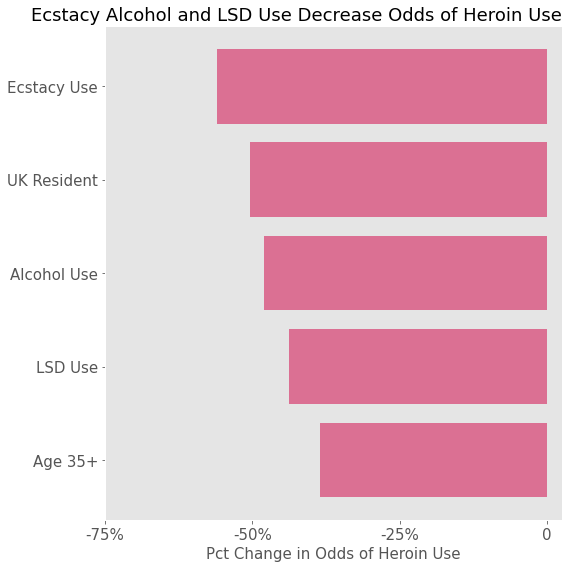

In [136]:
plt.figure(figsize=(8,8))
plt.barh(['Ecstacy Use', 'UK Resident', 'Alcohol Use', 'LSD Use', 'Age 35+'][-1::-1], list(five_neg.keys())[-1::-1], color="palevioletred")
plt.xlim([-.75,0.025])
plt.grid(b=False)
plt.yticks(size=15)
plt.xticks(ticks=[-.75, -.5, -.25, 0], labels=['-75%', '-50%', '-25%', '0'], size=15)
plt.xlabel('Pct Change in Odds of Heroin Use', size=15)
plt.title('Ecstacy Alcohol and LSD Use Decrease Odds of Heroin Use', loc='right', size=18)
plt.tight_layout()
plt.savefig('5NIP.png')
plt.show()

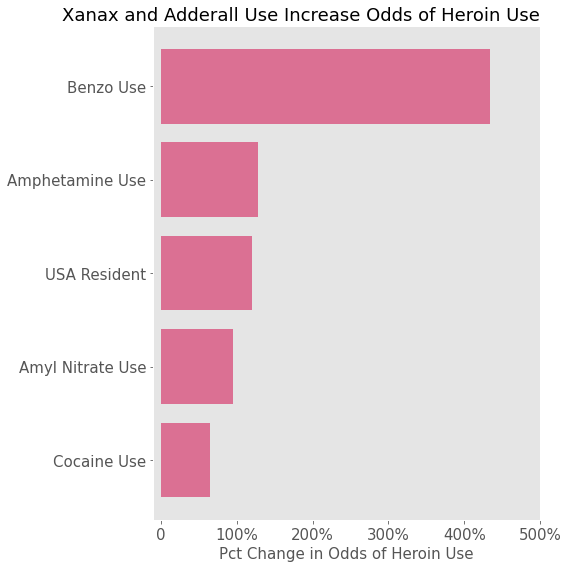

In [135]:
plt.figure(figsize=(8,8))
plt.barh(['Benzo Use', 'Amphetamine Use', 'USA Resident', 'Amyl Nitrate Use', 'Cocaine Use'][-1::-1], list(five_pos.keys()), color="palevioletred")
plt.grid(b=False)
plt.xlim([-0.1,5])
plt.yticks(size=15)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['0', '100%', '200%', '300%', '400%', '500%'], size=15)
plt.xlabel('Pct Change in Odds of Heroin Use', size=15)
plt.title('Xanax and Adderall Use Increase Odds of Heroin Use', loc='right', size=18)
plt.tight_layout()
plt.savefig('5PIP.png')
plt.show()

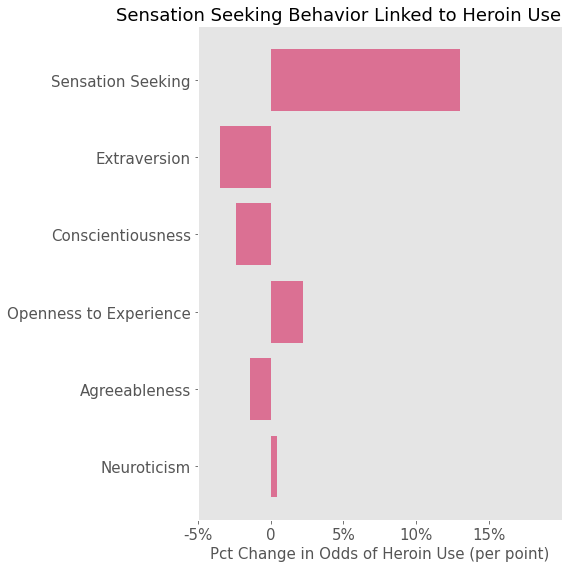

In [138]:
plt.figure(figsize=(8,8))
plt.barh(['Sensation Seeking', 'Extraversion', 'Conscientiousness', \
          'Openness to Experience', 'Agreeableness', 'Neuroticism'][-1::-1], \
         list(behavioral_scores_dict.values())[-1::-1], color="palevioletred")
plt.xlim([-.05,.2])
plt.grid(b=False)
plt.yticks(size=15)
plt.xticks(ticks=[-.05, 0, .05, .1, .15], labels=['-5%','0', '5%', '10%', '15%'], size=15)
plt.xlabel('Pct Change in Odds of Heroin Use (per point)', size=15)
plt.title('Sensation Seeking Behavior Linked to Heroin Use', size=18, loc='right')
plt.tight_layout()
plt.savefig('BSIP.png')
plt.show()

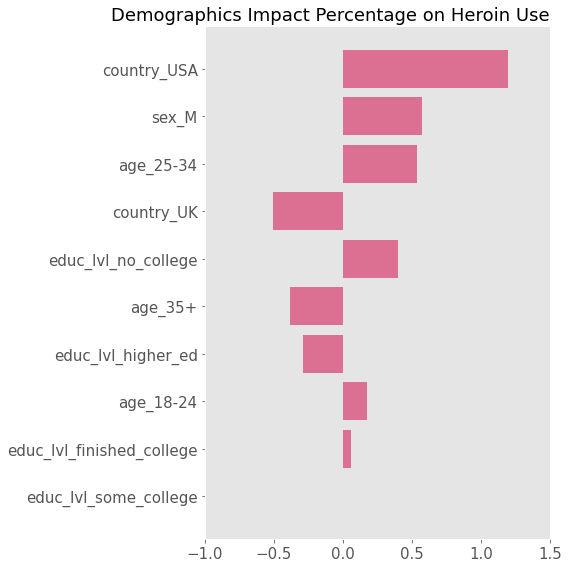

In [133]:
plt.figure(figsize=(8,8))
plt.barh(list(demographics_dict.keys())[-1::-1], list(demographics_dict.values())[-1::-1], color="palevioletred")
plt.xlim([-1,1.5])
plt.grid(b=False)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title('Demographics Impact Percentage on Heroin Use', loc='right', size=18)
plt.tight_layout()
plt.savefig('DIP.png')
plt.show()

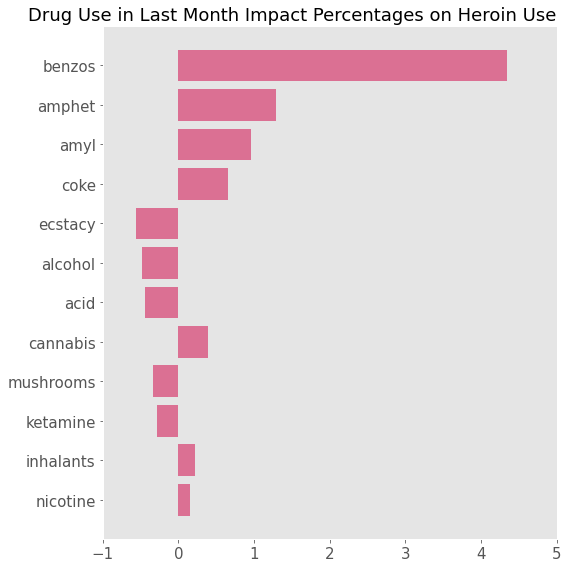

In [132]:
plt.figure(figsize=(8,8))
plt.barh(list(drug_survey_dict.keys())[-1::-1], list(drug_survey_dict.values())[-1::-1], color="palevioletred")
plt.xlim([-1,5])
plt.grid(b=False)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title('Drug Use in Last Month Impact Percentages on Heroin Use', loc='right', size=18)
plt.tight_layout()
plt.savefig('DUIP.png')
plt.show()